In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 1. Libraries

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Data Analysis



In [ ]:
#data set
DATA_DIR = "/content/drive/MyDrive/UTKDataset/AGE.csv"
IMG_DIR = "/content/drive/MyDrive/UTKDataset/UTKFace"
HIST_DIR = "/content/drive/MyDrive/UTKDataset/history.csv"
TRAIN_TEST_SPLIT = 0.7

#image width and height all images have to be uniform
IMG_WIDTH = IMG_HEIGHT = 180
#0 is male 1 is female
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP

({0: 'male', 1: 'female'}, {'female': 1, 'male': 0})

## Create a csv file for the dataset
Since we have already saved the csv file, we don't need to run these lines anymore

In [ ]:
# def parse_filepath(filepath):
#     try:
#       path, filename = os.path.split(filepath)
#       filename, ext = os.path.splitext(filename)
#       age, gender, ethnicity, _ = filename.split("_")
#       return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(ethnicity)]
#     except Exception as e:
#         print(filepath)
#         return None, None, None

# files = glob.glob(os.path.join(IMG_DIR, "*.jpg"))
# attributes = list(map(parse_filepath, files))

In [ ]:
# df = pd.DataFrame(attributes)
# df['file'] = files
# df.columns = ['age', 'gender', 'ethnicity', 'file']
# df = df.dropna()
# df.head()

In [ ]:
# df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
# df['ethnicity_id'] = df['ethnicity'].map(lambda ethnicity: RACE_ID_MAP[ethnicity])
# df.head()

In [ ]:
# path = '/content/drive/MyDrive/UTKDataset/AGE.csv'
# df.to_csv(path, encoding='utf-8', index=False, header=True)

## Loading dataset csv file

In [ ]:
data = pd.read_csv(DATA_DIR)
df = pd.DataFrame(data)
df.head()

,age,gender,ethnicity,file,gender_id,ethnicity_id
0,70.0,female,white,/content/drive/MyDrive/UTKDataset/UTKFace/70_1...,1,0
1,66.0,female,white,/content/drive/MyDrive/UTKDataset/UTKFace/66_1...,1,0
2,71.0,male,asian,/content/drive/MyDrive/UTKDataset/UTKFace/71_0...,0,2
3,7.0,female,indian,/content/drive/MyDrive/UTKDataset/UTKFace/7_1_...,1,3
4,78.0,female,white,/content/drive/MyDrive/UTKDataset/UTKFace/78_1...,1,0


In [ ]:
# df.describe()

In [ ]:
# Using age range (10, 65)
df = df[(df['age'] > 10) & (df['age'] < 65)]

#3. Data Generator

In [ ]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

p = np.random.permutation(len(df))

train_up_to = int(len(df) * TRAIN_TEST_SPLIT)      
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]


def preprocess_image(img_path):   # Used to perform some minor preprocessing on the image before inputting into the network.
    im = Image.open(img_path)
    im = im.resize((IMG_WIDTH, IMG_HEIGHT))
    im = np.array(im) / 255.0
    return im
        
def generate_images(image_idx, is_training, batch_size=16):  # Used to generate a batch with images when training/validating our model.
    
    # arrays to store our batched data
    images, ages, genders = [], [], []

    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            
            age = person['age']
            gender = person['gender_id']
            file = person['file']
            
            im = preprocess_image(file)
            genders.append(to_categorical(gender, 2))
            ages.append(age / df['age'].max())
            images.append(im)
            
            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []
                
        if not is_training:
            break

#4. CNN Model

In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import Dropout, Flatten, MaxPooling2D, SeparableConv2D, Activation, SpatialDropout2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def default_layers(inputs):
  x = SeparableConv2D(32,kernel_size=(3, 3),padding = 'same') (inputs)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = BatchNormalization()(x)

  x = SeparableConv2D(64,kernel_size=(3, 3),padding = 'same') (inputs)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = BatchNormalization()(x)

  x = SeparableConv2D(128,kernel_size=(3, 3),padding = 'same') (x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = BatchNormalization()(x)

  x = SeparableConv2D(128,kernel_size=(3, 3),padding = 'same') (x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)

  x = SeparableConv2D(256,kernel_size=(3, 3),padding = 'same') (x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)

  x = SeparableConv2D(256,kernel_size=(3, 3),padding = 'same') (x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = SpatialDropout2D(0.15)(x)
  x = BatchNormalization()(x)

  return x


def build_age_output(inputs):
  x = default_layers(inputs)
  x = Flatten()(x)

  x = Dense(128, kernel_regularizer=l2(0.03), activation='relu')(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)

  x = Dense(64, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)

  x = Dense(32, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)

  x = Dense(1, activation='sigmoid', name="age_output")(x)

  return x


def build_gender_output(inputs):
  x = default_layers(inputs)
  x = Flatten()(x)

  x = Dense(64, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)

  x = Dense(32, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)

  x = Dense(2, activation='softmax', name="gender_output")(x)

  return x

In [ ]:
inputs = Input(shape = (IMG_HEIGHT,IMG_WIDTH, 3))
age_output = build_age_output(inputs)
gender_output = build_gender_output(inputs)

model = Model(inputs=inputs, outputs=[age_output, gender_output], name="Face_Dectection")
#model.summary()

In [ ]:
import math
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def step_decay(epoch):
	initial_lrate = 0.002
	drop = 0.5
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(learning_rate=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'gender_output': 'categorical_crossentropy'},
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy'})

callbacks_list = [lrate]

#5. Training

In [ ]:
batch_size = 64
valid_batch_size = 64

train_gen = generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

history = model.fit(train_gen, steps_per_epoch = len(train_idx)//batch_size, epochs=22  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/22
141/141 [==============================] - 2407s 17s/step - loss: 1.1345 - age_output_loss: 0.0634 - gender_output_loss: 0.4442 - age_output_mae: 0.2010 - gender_output_accuracy: 0.7975 - val_loss: 0.9690 - val_age_output_loss: 0.0373 - val_gender_output_loss: 0.8006 - val_age_output_mae: 0.1547 - val_gender_output_accuracy: 0.5289 - lr: 0.0020
Epoch 2/22
141/141 [==============================] - 88s 627ms/step - loss: 0.3868 - age_output_loss: 0.0410 - gender_output_loss: 0.2447 - age_output_mae: 0.1626 - gender_output_accuracy: 0.9028 - val_loss: 1.0337 - val_age_output_loss: 0.0368 - val_gender_output_loss: 0.9147 - val_age_output_mae: 0.1563 - val_gender_output_accuracy: 0.5289 - lr: 0.0020
Epoch 3/22
141/141 [==============================] - 89s 634ms/step - loss: 0.3109 - age_output_loss: 0.0335 - gender_output_loss: 0.2088 - age_output_mae: 0.1462 - gender_output_accuracy: 0.9218 - val_loss: 0.6851 - val_age_output_loss: 0.0366 - val_gender_output_loss: 0.5772 - val

##Save model

In [ ]:
# model.save('/content/drive/MyDrive/UTKDataset/AG_model')
# model.save("/content/drive/MyDrive/UTKDataset/AG_model.h5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/UTKDataset/AG_model/assets


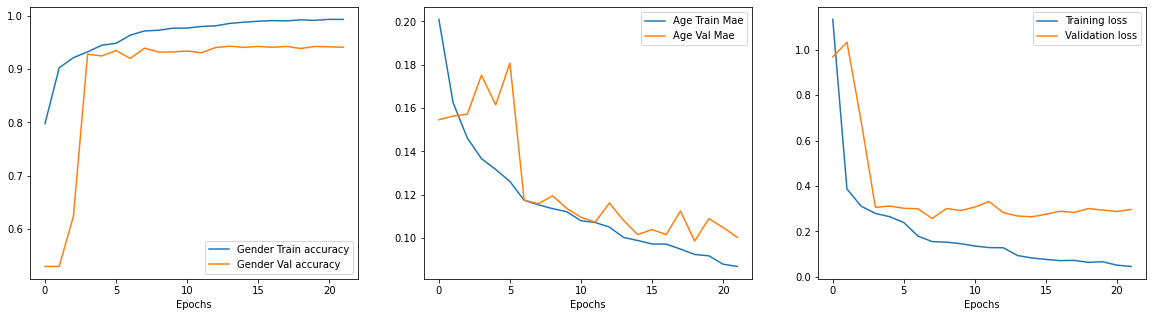

In [ ]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[0].plot(history.history['val_gender_output_accuracy'], label='Gender Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['age_output_mae'], label='Age Train Mae')
    axes[1].plot(history.history['val_age_output_mae'], label='Age Val Mae')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()  

    axes[2].plot(history.history['loss'], label='Training loss')
    axes[2].plot(history.history['val_loss'], label='Validation loss')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

plot_train_history(history)

## Save training history

In [ ]:
# Convert the history.history dict to a pandas DataFrame:     
# history_df = pd.DataFrame(history.history) 

# Save as .csv file 
# with open(HIST_DIR, mode='w') as f:
#     history_df.to_csv(f)

#6. Evaluation

##Load model

In [ ]:
from tensorflow.keras.models import load_model
model2 = load_model('/content/drive/MyDrive/UTKDataset/AG_model')

## Load history

In [ ]:
hist = pd.read_csv(HIST_DIR)
hist

## Evaluation

In [ ]:
test_gen = generate_images(test_idx, is_training=False, batch_size=64)
test, (trueAge, trueGender) = next(test_gen)
agePredict, genderPredict = model2.predict_on_batch(test)

In [ ]:
trueGender = trueGender.argmax(axis=-1)
genderPredict = genderPredict.argmax(axis=-1)
trueAge = trueAge * df['age'].max()
agePredict = agePredict * df['age'].max()

In [ ]:
from sklearn.metrics import classification_report

print("\nClassification report for gender")
print(classification_report(trueGender, genderPredict))


Classification report for gender
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       1.00      0.95      0.97        38

    accuracy                           0.97        64
   macro avg       0.96      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64



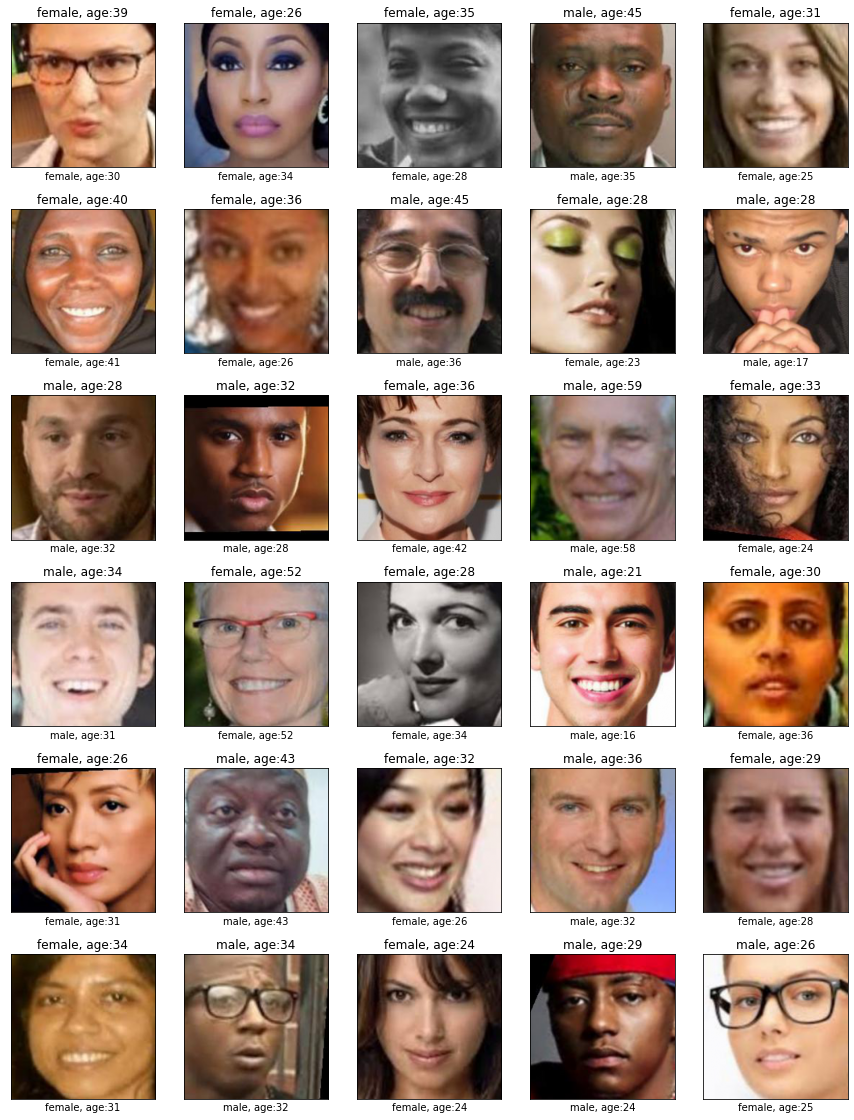

In [ ]:
import math
n = 30
rand_idx = np.random.permutation(n)     #shuffle don't need to print all
columns = 5

rows = math.ceil(n / columns)
fig, axes = plt.subplots(rows, columns, figsize=(15, 20))

for i, img in enumerate(rand_idx):
    ax = axes.flat[i]
    ax.imshow(test[img])
    ax.set_title('{}, age:{}'.format(ID_GENDER_MAP[genderPredict[img]], int(agePredict[img])))  #make a label on top for the predictions
    ax.set_xlabel('{}, age:{}'.format(ID_GENDER_MAP[trueGender[img]], int(trueAge[img])))       #label on bottom with true gender and age
    ax.set_xticks([]) #no tic marks
    ax.set_yticks([]) #no tic marks

#7. Real-time Testing

In [ ]:
!pip install cvlib

     |████████████████████████████████| 13.1 MB 3.9 MB/s 
  Created wheel for cvlib: filename=cvlib-0.2.7-py3-none-any.whl size=10046385 sha256=f7d761fbf2a5914154f1d5bbc8bf847a2534159ab92a234fd41a23f10d6b3c15
  Stored in directory: /root/.cache/pip/wheels/8e/d7/31/bc643bd3a8b11a7368b1ab1d8a6299b33b462ed0b0683ddc5a
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=b851ef50be05926d7f46bfdbbb4ab0e7acd8a87e764e20208c1b6219e19a7c3c
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built cvlib progressbar


In [ ]:
from google.colab.patches import cv2_imshow

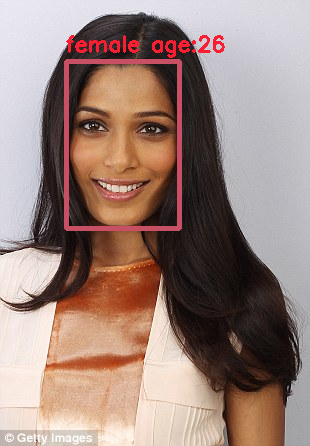

In [ ]:
from keras.preprocessing.image import img_to_array
import cv2
import cvlib as cv


#This will present an image we found on google and show a frame for the face with the label reading the predicted gender and age.

im = cv2.imread("/content/drive/MyDrive/UTKDataset/female_Face3.jpg")


#this will detect a face
face, confidence = cv.detect_face(im)

#loop for all the faces
for i, f in enumerate(face):
  #get corner points of face box
  (X1, Y1) = f[0], f[1]
  (X2, Y2) = f[2], f[3]

  #draw a box for the face
  cv2.rectangle(im, (X1, Y1), (X2, Y2), (100, 80, 200), 3)    #bgr so the 255 in the mid would be green. It should be pinkish and 3 is the thickness

  #crop the face
  crop = np.copy(im[Y1:Y2, X1:X2])

  
  #preprocessing for gender and age detection model
  crop = cv2.resize(crop, (180, 180))
  crop = crop.astype("float") / 255.0
  crop = img_to_array(crop)
  crop = np.expand_dims(crop, axis = 0)

  #Time for prediction
  agePredict, genderPredict = model2.predict_on_batch(crop)

  genderPredict = genderPredict.argmax(axis=-1)
  agePredict = int(agePredict * df['age'].max())

  gen = ID_GENDER_MAP[genderPredict[0]]
  label = "{} age:{} ".format(gen, agePredict)   
  
  Y = Y1 - 10 if Y1 - 10 > 10 else Y1 + 10

  #write label above face box
  cv2.putText(im, label, (X1, Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (50, 30, 250), 2)

#display output
cv2_imshow(im)